In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [6]:
# Load datasets
instruments = pd.read_csv("../Data/project2_instruments.csv")
trades = pd.read_csv("../Data/project2_trading.csv")

print("Instruments sample:")
print(instruments.head())

print("\nTrades sample:")
print(trades.head())


Instruments sample:
  instrument_id symbol         instrument_name   asset_class exchange  \
0    INST_00001   EQSU          Superior Group  Fixed Income     NYSE   
1    INST_00002   WYUT      Global Enterprises     Commodity      LSE   
2    INST_00003   ZCLW            Dynamic Corp   Derivatives      TSE   
3    INST_00004   QYNK     Strategic Solutions        Crypto      LSE   
4    INST_00005   YTEP  Superior Manufacturing     Commodity      TSE   

       sector  market_cap_usd  avg_daily_volume      beta  volatility_30d  \
0   Financial    1.151404e+11      2.651141e+07 -0.738669        1.032915   
1  Healthcare    1.621521e+12      3.810619e+06 -1.517421        0.203198   
2      Energy    1.437219e+12      1.458938e+07  2.900766        1.467826   
3      Energy    1.262599e+12      1.804662e+06  0.867632        2.332595   
4   Financial    4.360767e+11      4.480747e+07 -0.910945        2.124709   

   sharpe_ratio  correlation_to_index  dividend_yield    pe_ratio  \
0      0.

In [7]:
# Create returns matrix
returns = trades.pivot_table(
    index="timestamp",
    columns="instrument_id",
    values="pnl_usd"
).pct_change().dropna()
id_to_name = dict(zip(instruments["instrument_id"], instruments["instrument_name"]))
returns.rename(columns=id_to_name, inplace=True)

mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Mean Returns:")
print(mean_returns.head())

print("\nCovariance Matrix:")
print(cov_matrix.head())


C:\Users\prasa\AppData\Local\Temp\ipykernel_20336\1074328203.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ).pct_change().dropna()


Mean Returns:
instrument_id
Superior Group            0.000661
Global Enterprises       -0.000389
Dynamic Corp              0.000360
Strategic Solutions      -0.001935
Superior Manufacturing   -0.000469
dtype: float64

Covariance Matrix:
instrument_id           Superior Group  Global Enterprises  Dynamic Corp  \
instrument_id                                                              
Superior Group            9.287742e-03        2.571928e-07 -2.380614e-07   
Global Enterprises        2.571928e-07        1.806518e-03  1.403063e-07   
Dynamic Corp             -2.380614e-07        1.403063e-07  6.309563e-03   
Strategic Solutions       1.278597e-06       -7.535670e-07  6.975126e-07   
Superior Manufacturing    3.095982e-07       -1.824680e-07  1.688950e-07   

instrument_id           Strategic Solutions  Superior Manufacturing  \
instrument_id                                                         
Superior Group                 1.278597e-06            3.095982e-07   
Global Enterpris

In [8]:
# Portfolio return
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


In [9]:
assets = returns.columns.tolist()
num_assets = len(assets)

# Initial guess = equal weights
initial_weights = num_assets * [1./num_assets]
bounds = tuple((0,0.3) for asset in range(num_assets))  # max 30% per asset
constraints = ({'type':'eq','fun': lambda w: np.sum(w) - 1})

# Minimize volatility
opt = minimize(portfolio_volatility, initial_weights,
               args=(cov_matrix,),
               method='SLSQP', bounds=bounds,
               constraints=constraints)

opt_weights = opt.x


In [10]:
target_weights = pd.DataFrame({
    "Instrument": assets,
    "Target Weight": opt_weights
})

target_weights.to_csv("target_weights.csv", index=False)
print("Target weights saved: target_weights.csv")


Target weights saved: target_weights.csv


In [11]:
# Approximate current weights
current_weights = trades.groupby("instrument_id")["portfolio_weight"].mean()
current_weights = current_weights.reindex(assets).fillna(0)

transition = opt_weights - current_weights.values

trade_recommendations = pd.DataFrame({
    "Instrument": assets,
    "Current Weight": current_weights.values,
    "Target Weight": opt_weights,
    "Change (Buy/Sell)": transition
})

trade_recommendations.to_csv("trade_recommendations.csv", index=False)
print("Trade recommendations saved: trade_recommendations.csv")


Trade recommendations saved: trade_recommendations.csv


In [12]:
# Approximate current weights
current_weights = trades.groupby("instrument_id")["portfolio_weight"].mean()
current_weights = current_weights.reindex(assets).fillna(0)

transition = opt_weights - current_weights.values

trade_recommendations = pd.DataFrame({
    "Instrument": assets,
    "Current Weight": current_weights.values,
    "Target Weight": opt_weights,
    "Change (Buy/Sell)": transition
})

trade_recommendations.to_csv("trade_recommendations.csv", index=False)
print("Trade recommendations saved: trade_recommendations.csv")


Trade recommendations saved: trade_recommendations.csv


In [13]:
expected_ret = portfolio_return(opt_weights, mean_returns)
expected_vol = portfolio_volatility(opt_weights, cov_matrix)
sharpe_ratio = expected_ret / expected_vol

risk_report = pd.DataFrame({
    "Expected Return": [expected_ret],
    "Expected Volatility": [expected_vol],
    "Sharpe Ratio": [sharpe_ratio]
})

risk_report.to_csv("portfolio_risk_return.csv", index=False)
print("Risk/Return report saved: portfolio_risk_return.csv")


Risk/Return report saved: portfolio_risk_return.csv


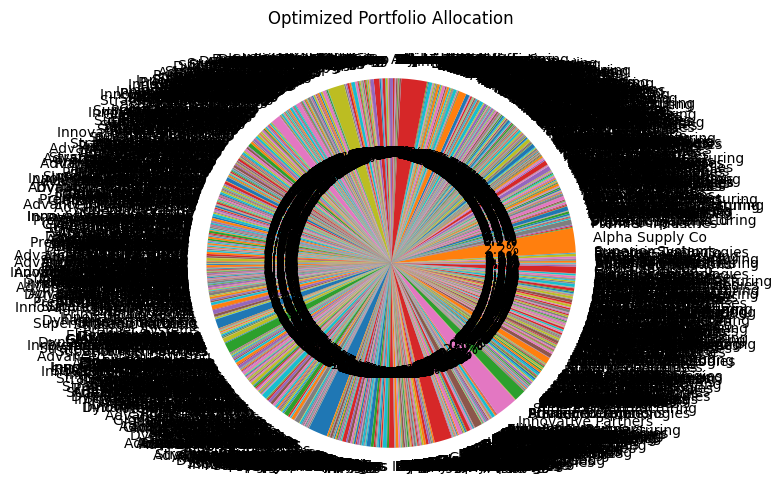

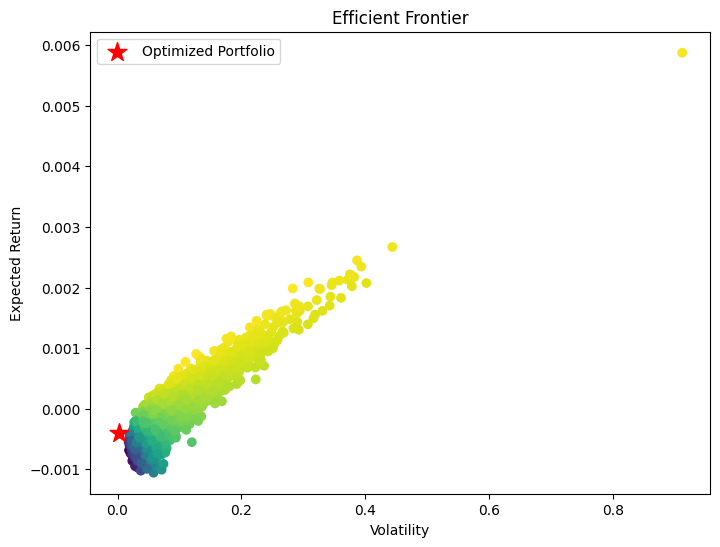

In [14]:
# Pie chart of optimized weights
plt.figure(figsize=(6,6))
plt.pie(opt_weights, labels=assets, autopct='%1.1f%%')
plt.title("Optimized Portfolio Allocation")
plt.show()

# Efficient frontier (basic)
returns_list = []
volatility_list = []

for i in range(5000):
    w = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    returns_list.append(portfolio_return(w, mean_returns))
    volatility_list.append(portfolio_volatility(w, cov_matrix))

plt.figure(figsize=(8,6))
plt.scatter(volatility_list, returns_list, c=np.array(returns_list)/np.array(volatility_list), cmap='viridis', marker='o')
plt.scatter(expected_vol, expected_ret, c='red', marker='*', s=200, label='Optimized Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()
